# USA Evictions Analysis

In [94]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = 15,11
sns.set(style="darkgrid")

In [95]:
#Import data
us_df = pd.read_csv("us.csv")

In [96]:
#Data cleanup
us_df.columns = [name.replace("-","_") for name in us_df.columns]   #Replace "-" with "_" in column titles. Easier to use .query()
us_df['name'] = list(map(str, us_df['name']))   #Change type to string for all elements of name column.
us_df = us_df[us_df['name'].str.match('^[0-9]')==False] #Remove any row where name column starts with a digit. We don't want tracts.
states = us_df.filter(["name","parent_location"]).query("parent_location == 'USA'")["name"].unique()    #Create a list of all states in the data.
counties = us_df["name"][us_df["name"].str.lower().str.contains("county")]  #Create a list of all rows with the word county in the name.
cities = us_df["name"][us_df["name"].str.lower().str.contains("city")]  #Create a list of all rows with the word city in the name.
us_df["tuple"] = list(zip(us_df["name"],us_df["parent_location"]))  #Add a column with the name and parent_location as a tuple for easier indexing.

# Data Exploration

First let's see how many rows and columns we have

In [97]:
pd.DataFrame(us_df.shape, columns=["us_df"], index=["Rows","Columns"])

,us_df
Rows,557175
Columns,28


Next, let's get a sense of what sort of data we have with the columns and data types, and determine how complete the data are with percent missing.

In [98]:
pd.DataFrame({"Data Type": us_df.dtypes, "Percent Null": us_df.isnull().sum() / len(us_df) * 100})

,Data Type,Percent Null
GEOID,int64,0.000000
year,int64,0.000000
name,object,0.000000
parent_location,object,0.000000
population,float64,8.358415
poverty_rate,float64,8.358415
renter_occupied_households,float64,18.935702
pct_renter_occupied,float64,8.358415
median_gross_rent,float64,18.115134
median_household_income,float64,10.719612


There seems to be a non-trivial amount of missing data, especially from the critical eviction related columns. Let's see if we can get a better idea of which locations are most effected by missing data.

In [99]:
missing_by_location = us_df.groupby(["name","parent_location"]).apply(lambda x: x['eviction_rate'].isna().sum()/17) #Each location should have 17 data points (one for each year from 2000-2016).

In [100]:
missing_by_location.sort_values(ascending=False)

name            parent_location
Chevy Chase     Maryland           2.000000
Riverside       New York           2.000000
Sunset          Texas              2.000000
Strawberry      California         1.823529
Woodbury        New York           1.823529
                                     ...   
Madison County  Montana            0.000000
                Nebraska           0.000000
                New York           0.000000
                North Carolina     0.000000
Aaronsburg      Pennsylvania       0.000000
Length: 32917, dtype: float64

Since we will be working off of averages, we will want to be sure that we are only looking at items with a sufficient amount of data. For that reason, we will drop all rows where location is associated with more than 0.2 percent of eviction_rate data missing.

Before we do that, let's provide an analysis on parts of the data which won't be as impacted by the missing components.

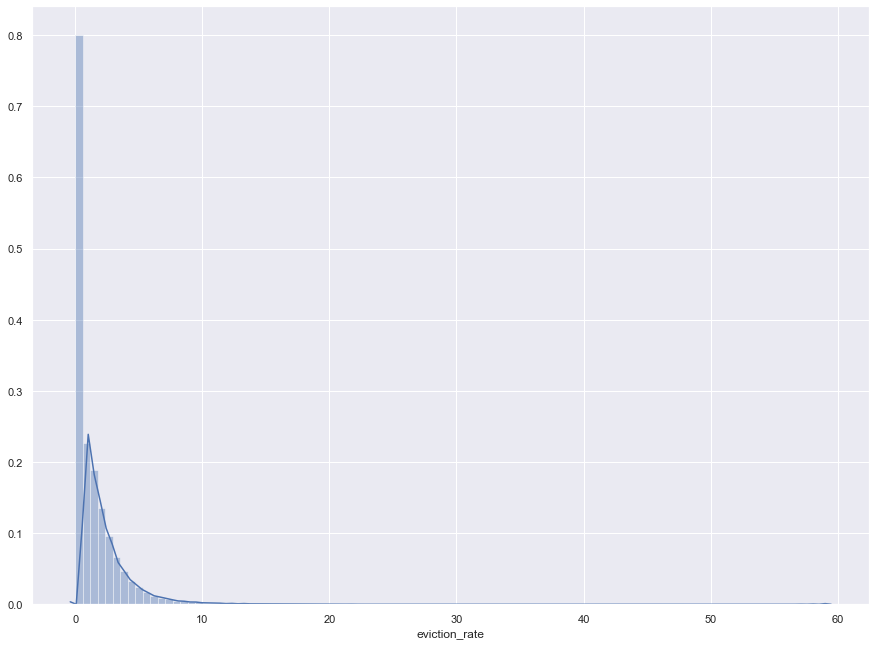

In [116]:
sns.distplot(us_df["eviction_rate"][us_df["eviction_rate"]<=100],bins=100)

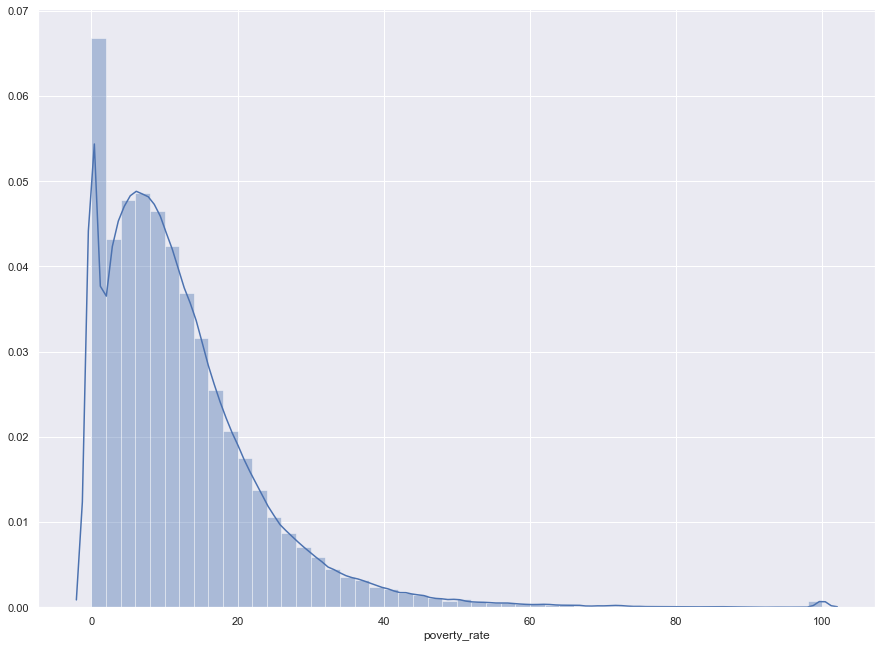

In [102]:
sns.distplot(us_df["poverty_rate"])

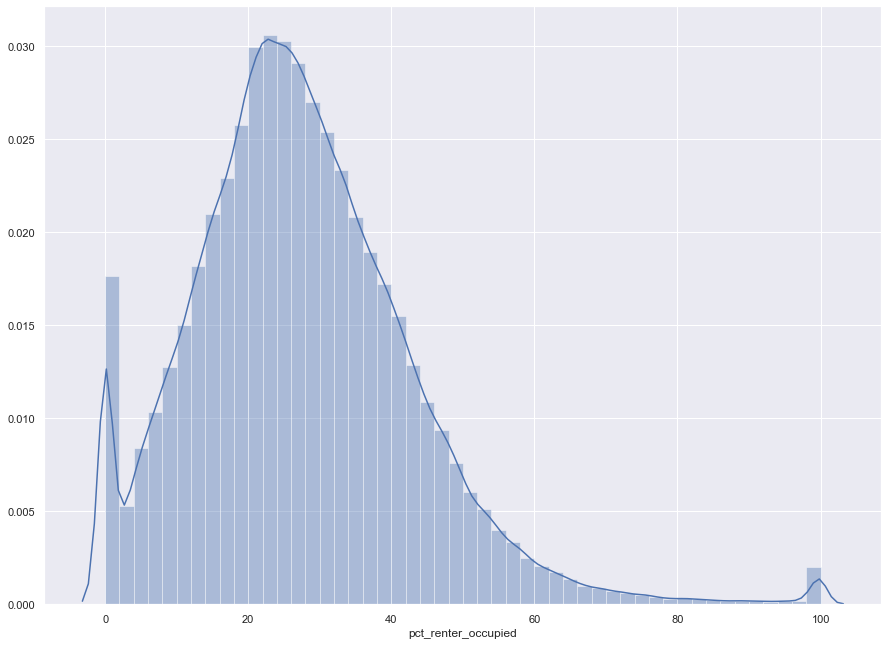

In [103]:
sns.distplot(us_df["pct_renter_occupied"])

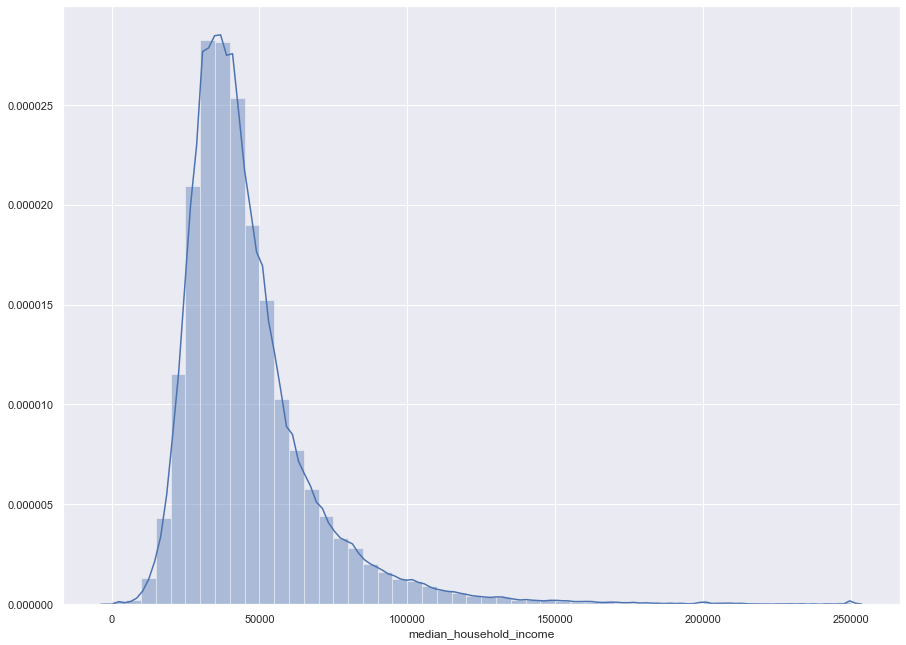

In [104]:
sns.distplot(us_df["median_household_income"])

Now that we have some visualizations of our data, we will go ahead and proceed with dropping rows with an unsuitable amount of data.

In [105]:
to_drop = list(missing_by_location[missing_by_location >0.01].index)
us_df = us_df[us_df["tuple"].isin(to_drop) == False]

Now let's check out our columns and nulls again.

In [106]:
pd.DataFrame({"Data Type": us_df.dtypes, "Percent Null": us_df.isnull().sum() / len(us_df) * 100})

,Data Type,Percent Null
GEOID,int64,0.000000
year,int64,0.000000
name,object,0.000000
parent_location,object,0.000000
population,float64,8.178384
poverty_rate,float64,8.178384
renter_occupied_households,float64,0.000000
pct_renter_occupied,float64,8.178384
median_gross_rent,float64,18.374249
median_household_income,float64,10.418784


In [107]:
us_df.shape

(249866, 28)

Clearly we have disposed of a good deal of the data, but our missing data is now manageable.

Now, let's look at the states and larger cities with the highest average eviction rate.

In [108]:
highest_avg_evicrate_states_df = us_df.query("parent_location=='USA'").groupby("name").agg("mean").sort_values(by="eviction_rate",ascending=False).head(5)
highest_avg_evicrate_states_df.filter(["eviction_rate"]).rename(columns={"eviction_rate":"avg_eviction_rate"})

,avg_eviction_rate
name,
Delaware,6.435294
Georgia,6.077647
Nevada,5.941176
Virginia,5.907647
Michigan,5.745294


In [109]:
highest_avg_evicrate_cities_df = us_df.query("parent_location in @states and population >= 100000 and name not in @counties and name not in @cities").groupby(["name","parent_location"]).agg("mean").sort_values(by="eviction_rate",ascending=False).head(5) #Show major cities (pop >= 100k) with highest average eviction rates.
highest_avg_evicrate_cities_df.filter(["eviction_rate"]).rename(columns={"eviction_rate":"avg_eviction_rate"})

,,avg_eviction_rate
name,parent_location,
Flint,Michigan,18.670909
Richmond,Virginia,11.348824
Lansing,Michigan,10.625294
Hampton,Virginia,9.883529
Portsmouth,Virginia,9.396000


Let's go ahead and plot out the eviction rate time-series for the top 10 states and cities.

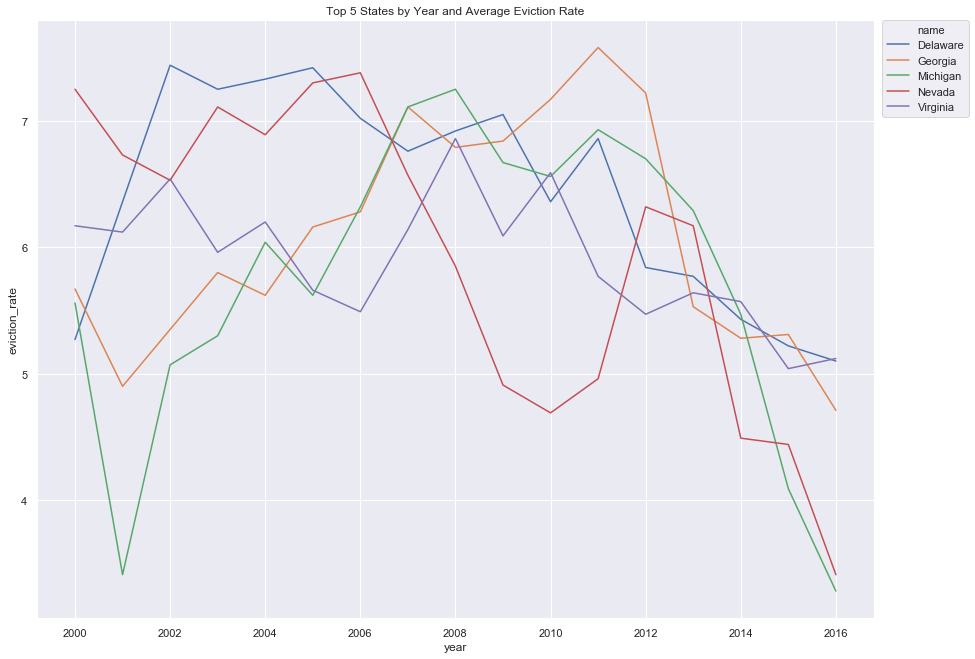

In [110]:
top_names = list(highest_avg_evicrate_states_df.index)
ts_data = us_df.query("name in @top_names and parent_location == 'USA'").filter(["year","name","eviction_rate"])
sns.lineplot(x="year",y="eviction_rate",data=ts_data,hue="name").set_title("Top 5 States by Year and Average Eviction Rate")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

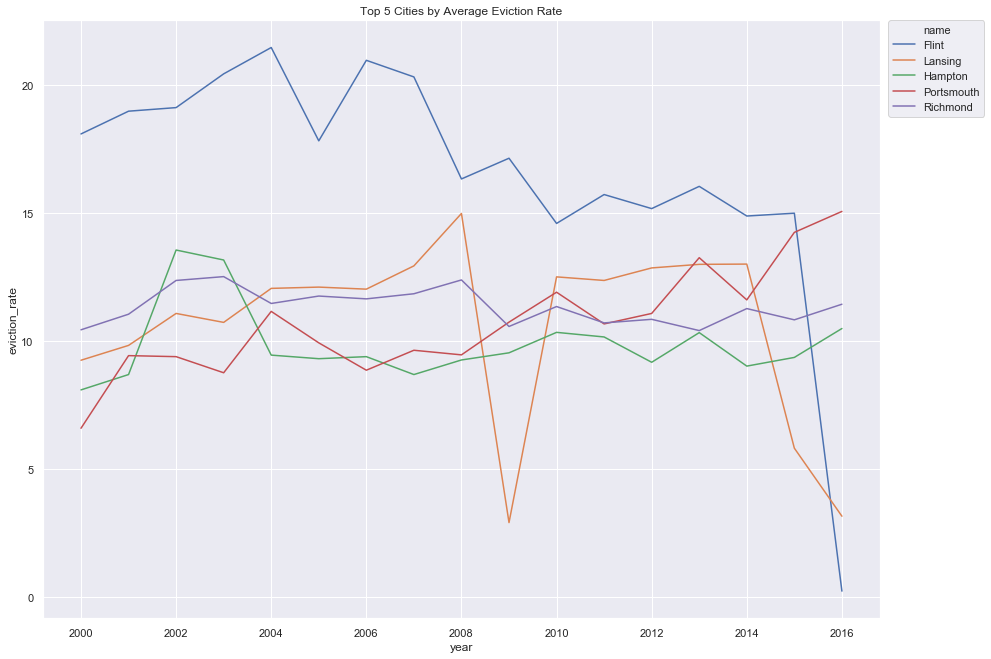

In [111]:
top_names = list(highest_avg_evicrate_cities_df.index)
ts_data = us_df[us_df["tuple"].isin(top_names)]
sns.lineplot(x="year",y="eviction_rate",data=ts_data,hue="name").set_title("Top 5 Cities by Average Eviction Rate")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

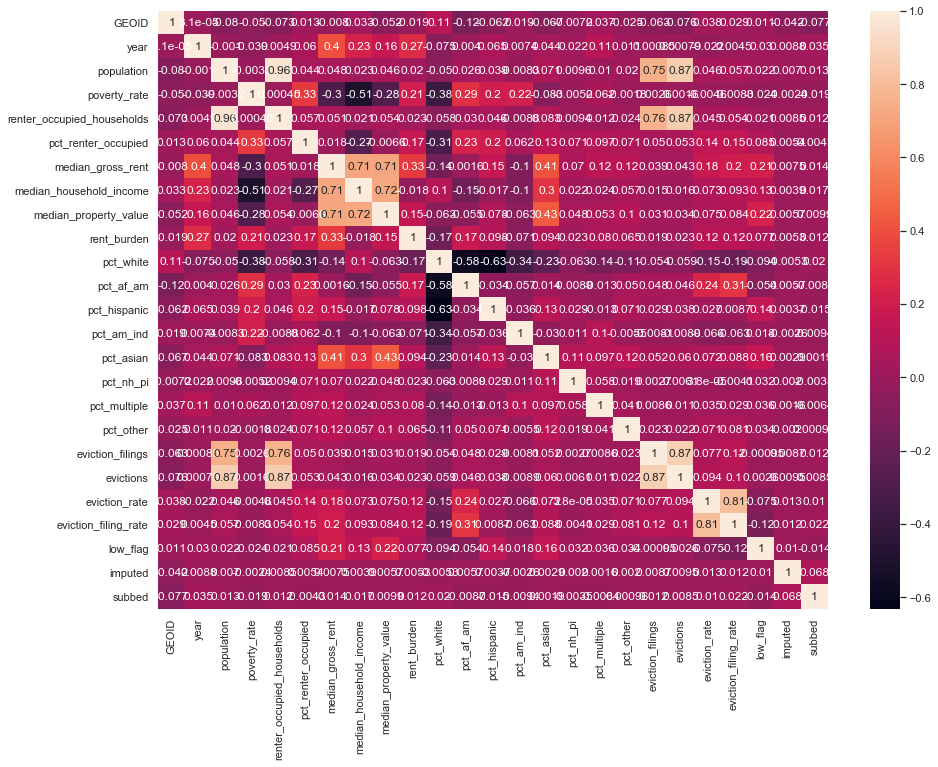

In [112]:
sns.heatmap(us_df.corr(),annot=True)

The heatmap shows that there don't seem to be any major correlations associated with eviction_rate, other than eviction_filing_rate which is to be expected. We also see that as population, and renter_occupied_households go up, evictions seem to increase&mdash;&mdash;as we might expect. However, there is one noteworthy observation to make:
- The percentage of white citizens has a negative correlation with poverty rate whereas the percentage of african american, hispanic, and american indian citizens all have a salient positive correlation with poverty rate.
- The percentage of white citizens has a negative correlation with pct_renter_occupied whereas the percentage of african american and hispanic citizens all have a salient positive correlation with pct_renter_occupied.
- pct_renter_occupied has a very strong correlation with population. This might suggest, as we would expect, that more densely populated areas such as cities see higher rates of renting.